In [825]:
import matplotlib.pyplot as plt
import numpy as nm
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [826]:
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'

# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_419.txt", sep="\t")
complete_df.fillna(complete_df.mean(), inplace=True)

C:\Users\vswen\AppData\Roaming\anaconda3\envs\deepchem-env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


In [827]:
# Fingerprint aanmaken
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['cpd_smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]


In [828]:
# Doelvariabele transformeren & limieten stellen dataframe
complete_df['ec50_mol'] = complete_df['apparent_ec50_umol'] / 1000000
complete_df['ec50_mol']=complete_df['ec50_mol'].replace(0, 1e-10)
complete_df['ec50_molair'] = complete_df['ec50_mol']/ complete_df['MolWt']
complete_df['ec50_molair_transformed'] = -nm.log10(complete_df['ec50_molair'])
condition = (complete_df['ec50_molair_transformed'] < 2 ) | (complete_df['ec50_molair_transformed'] > 8)
complete_df=complete_df[~condition]


In [829]:
# Dependent & Independent variable
#x = nm.array(complete_df['ecfp_bit_vectors'].tolist())
#y = complete_df['ec50_molair_transformed'].values
#z = complete_df['recurring_scaffold'].values

In [830]:
total_length_compounds = len(complete_df)
size_train_set = total_length_compounds * 0.8 # Uitgaande van idealiter een 0.8:0.2 verhouding tussen train en test

In [831]:
# Creeer een DF voor alle scaffolds die uniek zijn
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'ec50_molair_transformed']]

# Extraheer de X en Y value van de nieuwe DF 
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
y_unique = df_unique_scaffolds['ec50_molair_transformed'].values

In [832]:
# Creeer een DF voor alle scaffolds die meermaals voorkomen
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'ec50_molair_transformed', 'recurring_scaffold']]

# Extraheer de X, Y en Z value van de nieuwe DF
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup een eigen numerieke waarde
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist())
y_grouped = df_grouped_scaffolds['ec50_molair_transformed'].values
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist()
print(z_grouped)

#df_grouped_scaffolds_indexes = df_grouped_scaffolds.groupby('recurring_scaffold')

[23, 22, 22, 21, 21, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 13, 12, 11, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 5, 5, 4, 4, 3, 2, 2, 2, 2, 2, 2, 1, 1]


In [833]:
size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)
print(size_train_set_grouped_scaffolds)

36


In [834]:
# Creeeren van lege lijsten voor de Grouped Scaffolds
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

In [835]:
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else: 
        remaining = len(z_grouped)-x
        break
        
for x in range(remaining):
    x_test_grouped.append(x_grouped[x])
    y_test_grouped.append(y_grouped[x])

In [836]:
print(len(x_train_grouped))
print(len(x_test_grouped))
print(y_train_grouped[0:5])
print(y_test_grouped[0:5])

36
9
[6.177467919143146, 5.177786810229625, 3.06292216546177, 4.149560588087753, 5.585250661642195]
[6.177467919143146, 5.177786810229625, 3.06292216546177, 4.149560588087753, 5.585250661642195]


In [837]:
x_train_grouped = [list(arr) for arr in x_train_grouped]
x_test_grouped = [list(arr) for arr in x_test_grouped]

In [838]:
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

In [839]:
x_train_unique = [list(arr) for arr in x_train_unique]
x_test_unique = [list(arr) for arr in x_test_unique]

In [840]:
y_train_grouped[0]
y_train_unique[0]

4.254100482278787

In [841]:
x_train = nm.concatenate((x_train_grouped, x_train_unique))
x_test = nm.concatenate((x_test_grouped, x_test_unique))

y_train = nm.concatenate((y_train_grouped, y_train_unique))
y_test = nm.concatenate((y_test_grouped, y_test_unique))

In [842]:
print('TRAIN DATA')
print('y_train', len(y_train), y_train)
print('x_train', len(x_train), x_train)

print('TEST DATA')
print('x_test', len(x_test), x_test)
print('y_test', len(y_test), y_test)

TRAIN DATA
y_train 303 [6.17746792 5.17778681 3.06292217 4.14956059 5.58525066 2.50198468
 3.91956742 3.34657922 5.11197086 5.54643757 3.54245958 3.80396845
 7.00286775 7.14012004 4.79911746 7.97837982 5.92818719 4.88020939
 7.8379193  3.66170099 3.5604241  4.32983641 4.92716807 3.85277385
 5.85993903 4.47004173 3.26310969 4.48432501 4.05652758 4.75146563
 2.7613362  3.31549143 5.15262715 3.24403851 3.89107571 3.57066811
 4.25410048 3.64261256 3.49718226 4.00074561 3.22791598 6.81107136
 4.21821933 4.05913733 2.81014598 6.8726443  4.32680446 5.2293863
 4.7613378  5.19543885 5.40036102 3.12536341 6.57711339 4.59987641
 4.7769818  5.10886048 4.66224467 6.30261421 4.4148026  5.80930103
 3.97391901 5.8441365  5.36540427 4.23054297 4.25197765 4.31004416
 3.45807149 5.18799242 4.78139535 6.16761988 4.24802382 5.33616141
 4.06240482 4.49466625 5.47972253 3.77599875 3.91586322 4.0715542
 4.96976131 3.12522901 4.24233207 5.03976491 5.5420909  4.3457996
 6.16404616 5.35917126 3.76314556 7.861154

In [843]:

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [844]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train,y_train)

# Predict Test result
y_pred = regressor.predict(x_test)

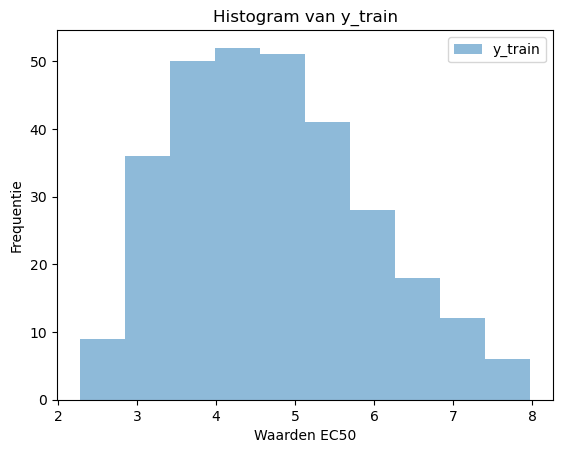

In [845]:
# Visualisatie y_train ## Vooral voor eigen begrip
plt.hist(y_train, alpha=0.5, label='y_train')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_train')
plt.legend()
plt.show()

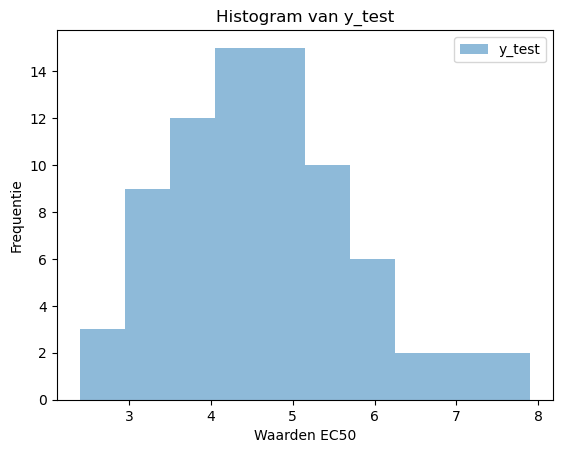

In [846]:
# Visualisatie y_test ## Vooral voor eigen begrip
plt.hist(y_test, alpha=0.5, label='y_test')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_test')
plt.legend()
plt.show()

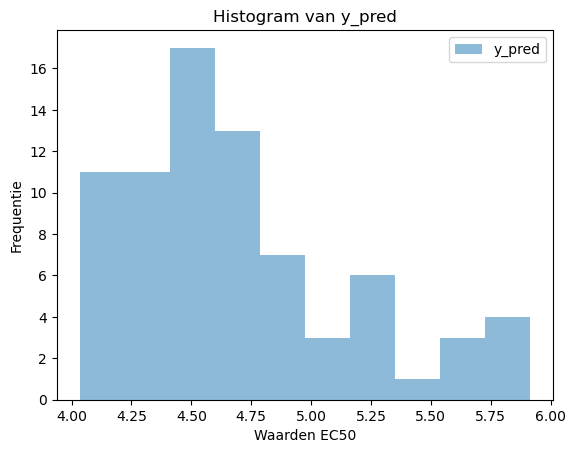

In [847]:
# Visualisatie y_pred ## Vooral voor eigen begrip
plt.hist(y_pred, alpha=0.5, label='y_pred')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_pred')
plt.legend()
plt.show()


In [848]:
# Errors berekenen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae=mean_absolute_error(y_test, y_pred)
print('mean absolute error is ', mae)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('mean squared error is ', mse)

# Root Mean Squared Error
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
r2 = r2_score(y_test, y_pred)
print('r2 is', r2)

mean absolute error is  0.7793709025172888
mean squared error is  0.9900941289304649
root mean squared error is  0.9950347375496319
r2 is 0.22780199980151195


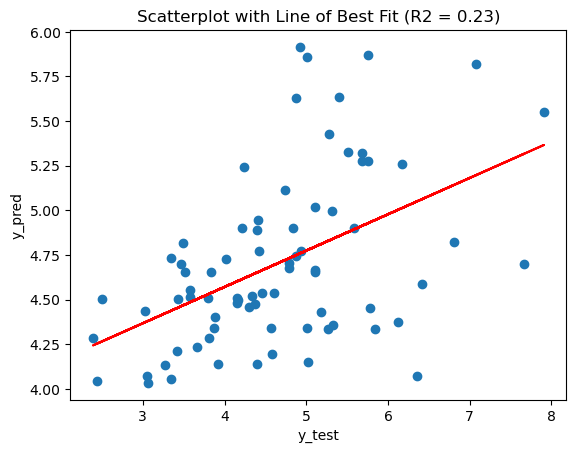

In [849]:
# R2 Visualisatie                                              
plt.scatter(y_test,y_pred)
plt.plot(y_test, line, color='red', label='line of current best fit')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()